In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
%matplotlib inline
%run env.py
%run src/supervision.py
session = SnorkelSession()
classes = get_candidate_classes()

In [2]:
from snorkel.models import Candidate, GoldLabel
candidate_class = classes.inducing_cytokine
cands = session.query(candidate_class.subclass)\
    .filter(candidate_class.subclass.split == SPLIT_DEV).all()
len(cands)

673

In [3]:
pd.Series([c.gold_labels[0].value if c.gold_labels else np.nan for c in cands]).value_counts()

1.0    133
dtype: int64

In [6]:
# Check on ordering (verify that type of first entity is always the same)
pd.Series([c.get_parent().entity_types[c.get_contexts()[0].get_word_start()] for c in cands]).value_counts()

cytokine    673
dtype: int64

In [7]:
pd.Series([ c.get_contexts()[0].get_word_start() < c.get_contexts()[1].get_word_start()  for c in cands]).value_counts()

False    342
True     331
dtype: int64

In [8]:
c = cands[0]
c.get_parent().text, c.get_contexts()[0]

('IL-12 induces not only Ifng expression1 but also T-bet,  which promotes the survival and proliferation of differentiating TH1 cells.   ',
 Span("b'IL-12'", sentence=13515, chars=[0,4], words=[0,0]))

In [9]:
ctx = c.get_contexts()[0]

### Export Training Data

In [26]:
def mark_entities(tokens, positions, markers=[], style="insert"):
    """Adds special markers around tokens at specific positions (e.g., entities)
    Args:
        tokens: A list of tokens (the sentence)
        positions:
            1) A list of inclusive ranges (tuples) corresponding to the
            token ranges of the entities in order. (Assumes each entity
            has only one corresponding mention.)
            OR
            2) A dict of lists with keys corresponding to mention indices and
            values corresponding to one or more inclusive ranges corresponding
            to that mention. (Allows entities to potentially have multiple
            mentions)
        markers: A list of strings (length of 2 * the number of entities) to
            use as markers of the entities.
        style: Where to apply the markers:
            'insert': Insert the markers as new tokens before/after each entity
            'concatenate': Prepend/append the markers to the first/last token
                of each entity
            If the tokens are going to be input to an LSTM, then it is usually
            best to use the 'insert' option; 'concatenate' may be better for
            viewing.
    Returns:
        toks: An extended list of tokens with markers around the mentions
    WARNING: if the marked token set will be used with pretrained embeddings,
        provide markers that will not result in UNK embeddings!
    Example:
        Input:  (['The', 'cat', 'sat'], [(1,1)])
        Output: ['The', '[[BEGIN0]]', 'cat', '[[END0]]', 'sat']
    """
    if markers and len(markers) != 2 * len(positions):
        msg = (
            f"Expected len(markers) == 2 * len(positions), "
            f"but {len(markers)} != {2 * len(positions)}."
        )
        raise ValueError(msg)

    toks = list(tokens)

    # markings will be of the form:
    # [(position, entity_idx), (position, entity_idx), ...]
    if isinstance(positions, list):
        markings = [(position, idx) for idx, position in enumerate(positions)]
    elif isinstance(positions, dict):
        markings = []
        for idx, v in positions.items():
            for position in v:
                markings.append((position, idx))
    else:
        msg = (
            f"Argument _positions_ must be a list or dict. "
            f"Instead, got {type(positions)}"
        )
        raise ValueError(msg)

    markings = sorted(markings)
    for i, ((si, ei), idx) in enumerate(markings):
        if markers:
            start_marker = markers[2 * idx]
            end_marker = markers[2 * idx + 1]
        else:
            start_marker = f"[[BEGIN{idx}]]"
            end_marker = f"[[END{idx}]]"
        if style == "insert":
            toks.insert(si + 2 * i, start_marker)
            toks.insert(ei + 2 * (i + 1), end_marker)
        elif style == "concatenate":
            toks[si] = start_marker + toks[si]
            toks[ei] = toks[ei] + end_marker
        else:
            raise NotImplementedError
    return toks


In [109]:
def get_text(cand):
    words = list(cand.get_parent().words)
    spans = cand.get_contexts()
    positions = [spans[0].get_word_range(), spans[1].get_word_range()]
#     return ' '.join(mark_entities(words, positions, style='concatenate', markers=[
#         '[[', ']]', '<<', '>>'
#     ]))
    return ' '.join(mark_entities(words, positions, style='insert', markers=[
        '[[', ']]', '<<', '>>'
    ]))

df = pd.DataFrame([
    dict(
        guid=c.id,
        text=get_text(c),
        label=c.gold_labels[0].value if c.gold_labels else 0
    ) 
    for c in cands
])
pd.set_option('display.max_colwidth', 250)
df.head()

,guid,label,text
0,30167,1,"[[ IL-12 ]] induces not only Ifng expression1 but also T - bet , which promotes the survival and proliferation of differentiating << TH1 >> cells ."
1,30168,0,"IL-12 induces not only [[ Ifng ]] expression1 but also T - bet , which promotes the survival and proliferation of differentiating << TH1 >> cells ."
2,30169,1,"In mice , [[ TGFβ ]] together with IL6 can activate antigen - responsive naïve CD4 + T cells to develop into << Th17 >> cells [ 39 ] ."
3,30170,1,"In mice , TGFβ together with [[ IL6 ]] can activate antigen - responsive naïve CD4 + T cells to develop into << Th17 >> cells [ 39 ] ."
4,30171,0,"Several findings suggest that during the initiation of a << Th1 >> response , [[ IL-12 ]] is produced particularly by macrophages in response to certain microbial antigens , while NK cells are the main source of IFN-γ in response to IL-12 ( 7 , 1..."


In [53]:
df['label'].value_counts()

0    540
1    133
Name: label, dtype: int64

In [54]:
df['label'].value_counts(normalize=True)

0    0.802377
1    0.197623
Name: label, dtype: float64

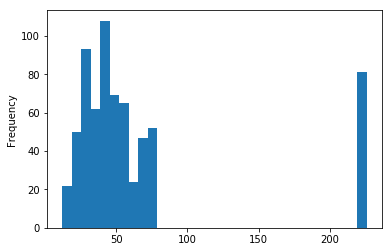

In [55]:
# Approximate token list length distribution
df['text'].str.split().str.len().plot('hist', bins=32)

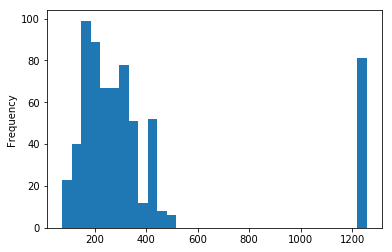

In [56]:
# String length distribution
%matplotlib inline
df['text'].str.len().plot('hist', bins=32)

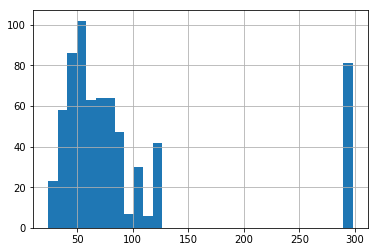

In [60]:
model_path = '/Users/eczech/tmp/scibert/scibert_scivocab_uncased'
from pytorch_pretrained_bert import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
df['text'].apply(lambda v: len(tokenizer.tokenize(v))).hist(bins=32)

In [62]:
!mkdir -p /tmp/bert_test/input

In [63]:
path = '/tmp/bert_test/input/train.csv'
df.to_csv(path, encoding='utf-8', index=False)
path

'/tmp/bert_test/input/train.csv'

In [64]:
path = '/tmp/bert_test/input/dev.csv'
df.to_csv(path, encoding='utf-8', index=False)
path

'/tmp/bert_test/input/dev.csv'

### Training Command

```bash
cd /Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/bert
python training.py \
--data_dir=/tmp/bert_test/input \
--bert_model=/Users/eczech/tmp/scibert/scibert_scivocab_uncased \
--task_name=tcre \
--output_dir=/tmp/bert_test/output \
--max_seq_length=128 \
--do_train \
--do_eval \
--do_lower_case \
--train_batch_size=32 \
--num_train_epochs=3 \
--no_cuda 
```

Eval only (note the bert_model change):

```bash
cd /Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/bert
python training.py \
--data_dir=/tmp/bert_test/input \
--bert_model=/tmp/bert_test/output \
--task_name=tcre \
--output_dir=/tmp/bert_test/output \
--max_seq_length=128 \
--do_eval \
--do_lower_case \
--train_batch_size=16 \
--num_train_epochs=3 \
--no_cuda 
```

In [61]:
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForSequenceClassification

In [6]:
model_path = '/Users/eczech/tmp/scibert/scibert_scivocab_uncased'

In [7]:
model = BertModel.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

### LSTM + Word2Vec

In [65]:
import spacy
import word2vec
nlp = spacy.load('en_core_sci_md')
model = word2vec.load('/Users/eczech/Downloads/PubMed-and-PMC-w2v.bin')

In [177]:
class Vectorizer(object):
    
    def __init__(self, model):
        self.model = model
        self.words = set(model.vocab)
        
    def indices(self, sentence):
        tokens = [w.text for w in nlp(sentence)]
        tokens = [t if t in self.words else 'UNK' for t in tokens]
        indices = [self.model.ix(t) for t in tokens]
        return np.array(indices), np.array(tokens)
    
    def embeddings(self, sentence):
        indices, tokens = self.indices(sentence)
        return np.stack([model.vectors[i] for i in indices]), tokens

In [178]:
vectorizer = Vectorizer(model)
idx, tkns = vectorizer.indices("il2 does stuff blahlbk")

In [179]:
idx, tkns

(array([864129,    484,  48451, 265456]),
 array(['il2', 'does', 'stuff', 'UNK'], dtype='<U5'))

In [180]:
vectorizer.indices('[[ IL-12 ]] induces')

(array([  61,   61, 5691,   60,   60, 1588]),
 array(['[', '[', 'IL-12', ']', ']', 'induces'], dtype='<U7'))

In [181]:
vectorizer.indices('<< TH1 >> cells')

(array([   86,    86, 28399,   198,   198,    30]),
 array(['<', '<', 'TH1', '>', '>', 'cells'], dtype='<U5'))

In [127]:
df.head()

,guid,label,text
0,30167,1,"[[ IL-12 ]] induces not only Ifng expression1 but also T - bet , which promotes the survival and proliferation of differentiating << TH1 >> cells ."
1,30168,0,"IL-12 induces not only [[ Ifng ]] expression1 but also T - bet , which promotes the survival and proliferation of differentiating << TH1 >> cells ."
2,30169,1,"In mice , [[ TGFβ ]] together with IL6 can activate antigen - responsive naïve CD4 + T cells to develop into << Th17 >> cells [ 39 ] ."
3,30170,1,"In mice , TGFβ together with [[ IL6 ]] can activate antigen - responsive naïve CD4 + T cells to develop into << Th17 >> cells [ 39 ] ."
4,30171,0,"Several findings suggest that during the initiation of a << Th1 >> response , [[ IL-12 ]] is produced particularly by macrophages in response to certain microbial antigens , while NK cells are the main source of IFN-γ in response to IL-12 ( 7 , 1..."


In [240]:
def featurize(df, vectorizer):
    X_train, Y_train = [], []
    for i, r in df.iterrows():
        indices, tokens = vectorizer.indices(r['text'])
        X_train.append(indices)
        Y_train.append(r['label'])
        assert r['label'] in [0, 1]
    return np.array(X_train), np.array(Y_train)

In [241]:
from sklearn.model_selection import train_test_split
X, Y = featurize(df, vectorizer)
idx_train, idx_test = train_test_split(np.arange(len(X)), test_size=.3, stratify=Y)
X_train, Y_train = X[idx_train], Y[idx_train]
X_test, Y_test = X[idx_test], Y[idx_test]

In [ ]:
idx

In [184]:
Y_train.shape, Y_train.dtype

((673,), dtype('int64'))

In [210]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim
import torch.nn.functional as F
from time import time


class LSTM(nn.Module):
        
    def __init__(self):
        super().__init__()
        self.lstm = None
        
    def build_model(self, embedding_model, hidden_dim=50, num_layers=1, 
                     dropout=0, bidirectional=False, max_seq_len=128,
                     **kwargs):
        self.embedding_model = embedding_model
        self.max_seq_len = max_seq_len
        self.cardinality = 2
        
        # Initialize and freeze embedding layer
        self.embedding_dim = self.embedding_model.vectors.shape[1]
        self.embedding_len = self.embedding_model.vectors.shape[0]
        self.embedding = nn.Embedding(self.embedding_len, self.embedding_dim, padding_idx=0)
        self.embedding.weight.requires_grad = False
        self.embedding.weight.data = torch.FloatTensor(self.embedding_model.vectors)

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim,
                            num_layers=num_layers, bidirectional=bidirectional,
                            dropout=dropout, batch_first=True)

        self.output_layer = nn.Linear(hidden_dim * self.num_directions, 
                                      self.cardinality if self.cardinality > 2 else 1)
        self.dropout_layer = nn.Dropout(p=dropout)
        
    def check_model(self, lr):
        if not hasattr(self, 'loss'):
            # Define loss and marginals ops
            if self.cardinality > 2:
                self.loss = cross_entropy_loss
            else:
                self.loss = nn.BCEWithLogitsLoss()
        if not hasattr(self, 'optimizer'):
            params = [param for param in self.parameters() if param.requires_grad == True]
            self.optimizer = optim.Adam(params, lr)
        
        
    def forward(self, X, hidden_state):
        """
        Args:
            X: Tensor with token indices (batch_size, max_batch_seq_length)
        """
        seq_lengths = torch.zeros((X.size(0)), dtype=torch.long)
        for i in range(X.size(0)):
            for j in range(X.size(1)):
                if X[i, j] == 0:
                    seq_lengths[i] = j
                    break
                seq_lengths[i] = X.size(1)

        seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
        X = X[perm_idx, :]
        inv_perm_idx = torch.tensor([i for i, _ in sorted(enumerate(perm_idx), key=lambda idx: idx[1])], dtype=torch.long)

        encoded_X = self.embedding(X)
        encoded_X = pack_padded_sequence(encoded_X, seq_lengths, batch_first=True)
        _, (ht, _) = self.lstm(encoded_X, hidden_state)
        output = ht[-1] if self.num_directions == 1 else torch.cat((ht[0], ht[1]), dim=1)

        return self.output_layer(self.dropout_layer(output[inv_perm_idx, :]))
    
    def _pytorch_outputs(self, X, batch_size):
        n = len(X)
        hidden_state = self.initialize_hidden_state(n)
        max_batch_length = min(max(map(len, X)), self.max_seq_len)

        padded_X = torch.zeros((n, max_batch_length), dtype=torch.long)
        for idx, seq in enumerate(X):
            # TODO: Don't instantiate tensor for each row
            nseq = min(len(seq), max_batch_length)
            padded_X[idx, :nseq] = torch.LongTensor(seq[:nseq])

        output = self.forward(padded_X, hidden_state)
        if self.cardinality == 2:
            return output.view(-1)
        else:
            return output

    
    def run_training(self, X_train, Y_train, n_epochs=25, lr=0.01, batch_size=32, seed=1):
        """
        Args:
            X_train: Array of numpy arrays containing each token index (each row can vary in length)
            Y_train: 1D numpy array of labels (0 or 1)
        """
        random_state = np.random.RandomState(seed=seed)
        n = len(X_train)
        train_idxs = np.arange(n)
        
#         self.build_model(**kwargs)
#         self.check_model(lr)
        
        # Run mini-batch SGD
        st = time()
        for epoch in range(n_epochs):
    
            # Shuffle training data
            train_idxs = random_state.permutation(list(range(n)))
            Y_train = Y_train[train_idxs]
            X_train = X_train[train_idxs]
            batch_size = min(batch_size, n) 
            epoch_losses = []

            nn.Module.train(self)
            for batch in range(0, n, batch_size):
                
                # zero gradients for each batch
                self.optimizer.zero_grad()
                
                if batch_size > len(X_train[batch:batch+batch_size]):
                    batch_size = len(X_train[batch:batch+batch_size])

                output = self._pytorch_outputs(X_train[batch:batch + batch_size], None)
                
                #Calculate loss
                calculated_loss = self.loss(output, torch.Tensor(Y_train[batch:batch+batch_size]))
                
                #Compute gradient
                calculated_loss.backward()
                
                #Step on the optimizer
                self.optimizer.step()
                
                epoch_losses.append(calculated_loss)
                
                msg = "Epoch {} ({:.2f}s)\tAverage loss={:.6f}, Current loss={:.6f}".format(
                    epoch+1, time() - st, torch.stack(epoch_losses).mean(), calculated_loss)
                print(msg)
        print('Training complete')
    
    def initialize_hidden_state(self, batch_size):
        return (
            torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim),
            torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim)
        )
        

In [211]:
emb_lstm = LSTM()

In [212]:
emb_lstm.build_model(model, hidden_dim=25)

In [213]:
emb_lstm.embedding.weight.dtype, emb_lstm.embedding.weight.shape

(torch.float32, torch.Size([4087446, 200]))

In [214]:
model.vectors.dtype, model.vectors.shape, len(model.vocab)

(dtype('float64'), (4087446, 200), 4087446)

In [215]:
emb_lstm.check_model(lr=0.01)

In [216]:
emb_lstm.run_training(X_train, Y_train, n_epochs=5, lr=0.01, batch_size=32, seed=1)

Epoch 1 (0.18s)	Average loss=0.639588, Current loss=0.639588
Epoch 1 (0.35s)	Average loss=0.630245, Current loss=0.620902
Epoch 1 (0.52s)	Average loss=0.606187, Current loss=0.558069
Epoch 1 (0.69s)	Average loss=0.587409, Current loss=0.531074
Epoch 1 (0.86s)	Average loss=0.541987, Current loss=0.360301
Epoch 1 (1.15s)	Average loss=0.595443, Current loss=0.862725
Epoch 1 (1.30s)	Average loss=0.595876, Current loss=0.598468
Epoch 1 (1.46s)	Average loss=0.582870, Current loss=0.491829
Epoch 1 (1.60s)	Average loss=0.571870, Current loss=0.483874
Epoch 1 (1.76s)	Average loss=0.572264, Current loss=0.575812
Epoch 1 (1.93s)	Average loss=0.557555, Current loss=0.410461
Epoch 1 (2.08s)	Average loss=0.545254, Current loss=0.409946
Epoch 1 (2.22s)	Average loss=0.537473, Current loss=0.444100
Epoch 1 (2.38s)	Average loss=0.522430, Current loss=0.326875
Epoch 1 (2.52s)	Average loss=0.511631, Current loss=0.360446
Epoch 1 (2.68s)	Average loss=0.506869, Current loss=0.435440
Epoch 1 (2.83s)	Average 

Epoch 2 (8.24s)	Average loss=0.580334, Current loss=0.252041
Epoch 2 (8.29s)	Average loss=0.577540, Current loss=0.253504
Epoch 2 (8.31s)	Average loss=0.583927, Current loss=1.331187
Epoch 2 (8.35s)	Average loss=0.581640, Current loss=0.311767
Epoch 2 (8.38s)	Average loss=0.589211, Current loss=1.490176
Epoch 2 (8.41s)	Average loss=0.587174, Current loss=0.342643
Epoch 2 (8.42s)	Average loss=0.585121, Current loss=0.336778
Epoch 2 (8.46s)	Average loss=0.583107, Current loss=0.337425
Epoch 2 (8.49s)	Average loss=0.581273, Current loss=0.355645
Epoch 2 (8.53s)	Average loss=0.579331, Current loss=0.338534
Epoch 2 (8.55s)	Average loss=0.577451, Current loss=0.342408
Epoch 2 (8.58s)	Average loss=0.575582, Current loss=0.340154
Epoch 2 (8.65s)	Average loss=0.572949, Current loss=0.238481
Epoch 2 (8.67s)	Average loss=0.571028, Current loss=0.325209
Epoch 2 (8.70s)	Average loss=0.569029, Current loss=0.311092
Epoch 2 (8.73s)	Average loss=0.567020, Current loss=0.305919
Epoch 2 (8.76s)	Average 

Epoch 2 (13.43s)	Average loss=0.524564, Current loss=1.520973
Epoch 2 (13.46s)	Average loss=0.523457, Current loss=0.243255
Epoch 2 (13.49s)	Average loss=0.527344, Current loss=1.514842
Epoch 2 (13.51s)	Average loss=0.526281, Current loss=0.255170
Epoch 2 (13.53s)	Average loss=0.530051, Current loss=1.494989
Epoch 2 (13.56s)	Average loss=0.529035, Current loss=0.268095
Epoch 2 (13.59s)	Average loss=0.528003, Current loss=0.261604
Epoch 2 (13.62s)	Average loss=0.526988, Current loss=0.264126
Epoch 2 (13.65s)	Average loss=0.526029, Current loss=0.276813
Epoch 2 (13.69s)	Average loss=0.525020, Current loss=0.261543
Epoch 2 (13.73s)	Average loss=0.524011, Current loss=0.259645
Epoch 2 (13.78s)	Average loss=0.522653, Current loss=0.165609
Epoch 2 (13.82s)	Average loss=0.521634, Current loss=0.252687
Epoch 2 (14.07s)	Average loss=0.520338, Current loss=0.176837
Epoch 2 (14.14s)	Average loss=0.519045, Current loss=0.175234
Epoch 2 (14.23s)	Average loss=0.517744, Current loss=0.170116
Epoch 2 

Epoch 2 (19.06s)	Average loss=0.506062, Current loss=0.223693
Epoch 2 (19.09s)	Average loss=0.505312, Current loss=0.214649
Epoch 2 (19.13s)	Average loss=0.504559, Current loss=0.211570
Epoch 2 (19.17s)	Average loss=0.507610, Current loss=1.697460
Epoch 2 (19.21s)	Average loss=0.506827, Current loss=0.200709
Epoch 2 (19.25s)	Average loss=0.506040, Current loss=0.197380
Epoch 2 (19.30s)	Average loss=0.505256, Current loss=0.197108
Epoch 2 (19.31s)	Average loss=0.504467, Current loss=0.193755
Epoch 2 (19.35s)	Average loss=0.503675, Current loss=0.190642
Epoch 2 (19.42s)	Average loss=0.502743, Current loss=0.133886
Epoch 2 (19.47s)	Average loss=0.501939, Current loss=0.182578
Epoch 2 (19.51s)	Average loss=0.501120, Current loss=0.175351
Epoch 2 (19.56s)	Average loss=0.500295, Current loss=0.170963
Epoch 2 (19.59s)	Average loss=0.499462, Current loss=0.166463
Epoch 2 (19.63s)	Average loss=0.498628, Current loss=0.164126
Epoch 2 (19.66s)	Average loss=0.497783, Current loss=0.157830
Epoch 2 

Epoch 2 (24.56s)	Average loss=0.517724, Current loss=1.547391
Epoch 2 (24.64s)	Average loss=0.516923, Current loss=0.095603
Epoch 2 (24.68s)	Average loss=0.516402, Current loss=0.241545
Epoch 2 (24.70s)	Average loss=0.515903, Current loss=0.252479
Epoch 2 (24.91s)	Average loss=0.517796, Current loss=1.519314
Epoch 2 (24.93s)	Average loss=0.517098, Current loss=0.146959
Epoch 2 (24.96s)	Average loss=0.518924, Current loss=1.488995
Epoch 2 (24.98s)	Average loss=0.518460, Current loss=0.271381
Epoch 2 (25.01s)	Average loss=0.520108, Current loss=1.398314
Epoch 2 (25.08s)	Average loss=0.519349, Current loss=0.114369
Epoch 2 (25.11s)	Average loss=0.518946, Current loss=0.303034
Epoch 2 (25.14s)	Average loss=0.518560, Current loss=0.311928
Epoch 2 (25.19s)	Average loss=0.518168, Current loss=0.307782
Epoch 2 (25.22s)	Average loss=0.517798, Current loss=0.318658
Epoch 2 (25.24s)	Average loss=0.517428, Current loss=0.318081
Epoch 2 (25.27s)	Average loss=0.517038, Current loss=0.305958
Epoch 2 

Epoch 2 (30.81s)	Average loss=0.504276, Current loss=0.034923
Epoch 2 (30.90s)	Average loss=0.503565, Current loss=0.032730
Epoch 2 (30.93s)	Average loss=0.503134, Current loss=0.217008
Epoch 2 (30.98s)	Average loss=0.502657, Current loss=0.186444
Epoch 2 (31.02s)	Average loss=0.502180, Current loss=0.184930
Epoch 2 (31.07s)	Average loss=0.504017, Current loss=1.727519
Epoch 2 (31.09s)	Average loss=0.503532, Current loss=0.179806
Epoch 2 (31.16s)	Average loss=0.502819, Current loss=0.026885
Epoch 2 (31.39s)	Average loss=0.502374, Current loss=0.204659
Epoch 2 (31.42s)	Average loss=0.501883, Current loss=0.172448
Epoch 2 (31.46s)	Average loss=0.501392, Current loss=0.172330
Epoch 2 (31.48s)	Average loss=0.500894, Current loss=0.165853
Epoch 3 (32.21s)	Average loss=1.874850, Current loss=1.874850
Epoch 3 (32.23s)	Average loss=1.018922, Current loss=0.162995
Epoch 3 (32.25s)	Average loss=1.306249, Current loss=1.880903
Epoch 3 (32.28s)	Average loss=1.022142, Current loss=0.169820
Epoch 3 

Epoch 3 (36.88s)	Average loss=0.537933, Current loss=0.054115
Epoch 3 (36.95s)	Average loss=0.534025, Current loss=0.053353
Epoch 3 (36.99s)	Average loss=0.531912, Current loss=0.269880
Epoch 3 (37.03s)	Average loss=0.530534, Current loss=0.358358
Epoch 3 (37.05s)	Average loss=0.529156, Current loss=0.355527
Epoch 3 (37.09s)	Average loss=0.527777, Current loss=0.352661
Epoch 3 (37.12s)	Average loss=0.526341, Current loss=0.342464
Epoch 3 (37.20s)	Average loss=0.522626, Current loss=0.043393
Epoch 3 (37.24s)	Average loss=0.521175, Current loss=0.332548
Epoch 3 (37.27s)	Average loss=0.526767, Current loss=1.259372
Epoch 3 (37.31s)	Average loss=0.525336, Current loss=0.336480
Epoch 3 (37.36s)	Average loss=0.523150, Current loss=0.232410
Epoch 3 (37.43s)	Average loss=0.519519, Current loss=0.032955
Epoch 3 (37.45s)	Average loss=0.525148, Current loss=1.284967
Epoch 3 (37.47s)	Average loss=0.523724, Current loss=0.330180
Epoch 3 (37.50s)	Average loss=0.529180, Current loss=1.276539
Epoch 3 

Epoch 3 (42.72s)	Average loss=0.514587, Current loss=1.670167
Epoch 3 (42.74s)	Average loss=0.513413, Current loss=0.206921
Epoch 3 (42.78s)	Average loss=0.512214, Current loss=0.198280
Epoch 3 (42.81s)	Average loss=0.516407, Current loss=1.619012
Epoch 3 (42.85s)	Average loss=0.520896, Current loss=1.706007
Epoch 3 (42.88s)	Average loss=0.524923, Current loss=1.592206
Epoch 3 (42.90s)	Average loss=0.523814, Current loss=0.228818
Epoch 3 (42.93s)	Average loss=0.522785, Current loss=0.247859
Epoch 3 (42.96s)	Average loss=0.521730, Current loss=0.238946
Epoch 3 (42.99s)	Average loss=0.520695, Current loss=0.242313
Epoch 3 (43.01s)	Average loss=0.519249, Current loss=0.128898
Epoch 3 (43.03s)	Average loss=0.518264, Current loss=0.251326
Epoch 3 (43.08s)	Average loss=0.517249, Current loss=0.241300
Epoch 3 (43.11s)	Average loss=0.516230, Current loss=0.237937
Epoch 3 (43.18s)	Average loss=0.514403, Current loss=0.013798
Epoch 3 (43.21s)	Average loss=0.513427, Current loss=0.245160
Epoch 3 

Epoch 3 (48.96s)	Average loss=0.504073, Current loss=0.231956
Epoch 3 (48.99s)	Average loss=0.506689, Current loss=1.547766
Epoch 3 (49.04s)	Average loss=0.506008, Current loss=0.234533
Epoch 3 (49.08s)	Average loss=0.505321, Current loss=0.230197
Epoch 3 (49.12s)	Average loss=0.504658, Current loss=0.238936
Epoch 3 (49.21s)	Average loss=0.503429, Current loss=0.009230
Epoch 3 (49.29s)	Average loss=0.502205, Current loss=0.009120
Epoch 3 (49.31s)	Average loss=0.501517, Current loss=0.223545
Epoch 3 (49.36s)	Average loss=0.500856, Current loss=0.233102
Epoch 3 (49.38s)	Average loss=0.503494, Current loss=1.574458
Epoch 3 (49.42s)	Average loss=0.502845, Current loss=0.238626
Epoch 3 (49.45s)	Average loss=0.502188, Current loss=0.234207
Epoch 3 (49.49s)	Average loss=0.501508, Current loss=0.223564
Epoch 3 (49.53s)	Average loss=0.500824, Current loss=0.220287
Epoch 3 (49.56s)	Average loss=0.500155, Current loss=0.225154
Epoch 3 (49.61s)	Average loss=0.499472, Current loss=0.217904
Epoch 3 

Epoch 3 (54.94s)	Average loss=0.479405, Current loss=0.006656
Epoch 3 (54.98s)	Average loss=0.478805, Current loss=0.158648
Epoch 3 (55.22s)	Average loss=0.478185, Current loss=0.147263
Epoch 3 (55.25s)	Average loss=0.477620, Current loss=0.175534
Epoch 3 (55.29s)	Average loss=0.479999, Current loss=1.755067
Epoch 3 (55.33s)	Average loss=0.482567, Current loss=1.861445
Epoch 3 (55.35s)	Average loss=0.485014, Current loss=1.801681
Epoch 3 (55.39s)	Average loss=0.484457, Current loss=0.184358
Epoch 3 (55.44s)	Average loss=0.483828, Current loss=0.143998
Epoch 3 (55.49s)	Average loss=0.486638, Current loss=2.006935
Epoch 3 (55.54s)	Average loss=0.486093, Current loss=0.190686
Epoch 3 (55.57s)	Average loss=0.485503, Current loss=0.164780
Epoch 3 (55.65s)	Average loss=0.484624, Current loss=0.006870
Epoch 3 (55.67s)	Average loss=0.484158, Current loss=0.230048
Epoch 3 (55.71s)	Average loss=0.483628, Current loss=0.194494
Epoch 3 (55.76s)	Average loss=0.483100, Current loss=0.193787
Epoch 3 

Epoch 3 (61.09s)	Average loss=0.488172, Current loss=0.112747
Epoch 3 (61.12s)	Average loss=0.487804, Current loss=0.242386
Epoch 3 (61.20s)	Average loss=0.487225, Current loss=0.101458
Epoch 3 (61.27s)	Average loss=0.489965, Current loss=2.320127
Epoch 3 (61.29s)	Average loss=0.489588, Current loss=0.237556
Epoch 3 (61.32s)	Average loss=0.491179, Current loss=1.557074
Epoch 3 (61.35s)	Average loss=0.490814, Current loss=0.245717
Epoch 3 (61.38s)	Average loss=0.492333, Current loss=1.512739
Epoch 4 (62.20s)	Average loss=0.239929, Current loss=0.239929
Epoch 4 (62.23s)	Average loss=0.244496, Current loss=0.249064
Epoch 4 (62.27s)	Average loss=0.242327, Current loss=0.237987
Epoch 4 (62.30s)	Average loss=0.240899, Current loss=0.236616
Epoch 4 (62.32s)	Average loss=0.485324, Current loss=1.463025
Epoch 4 (62.35s)	Average loss=0.445286, Current loss=0.245097
Epoch 4 (62.42s)	Average loss=0.404522, Current loss=0.159939
Epoch 4 (62.44s)	Average loss=0.385756, Current loss=0.254392
Epoch 4 

Epoch 4 (66.98s)	Average loss=0.505209, Current loss=0.085124
Epoch 4 (67.03s)	Average loss=0.512347, Current loss=1.447414
Epoch 4 (67.10s)	Average loss=0.509193, Current loss=0.092804
Epoch 4 (67.17s)	Average loss=0.506110, Current loss=0.096085
Epoch 4 (67.21s)	Average loss=0.504810, Current loss=0.330606
Epoch 4 (67.25s)	Average loss=0.503635, Current loss=0.345057
Epoch 4 (67.32s)	Average loss=0.500986, Current loss=0.140740
Epoch 4 (67.35s)	Average loss=0.499977, Current loss=0.361769
Epoch 4 (67.39s)	Average loss=0.498986, Current loss=0.362158
Epoch 4 (67.41s)	Average loss=0.504224, Current loss=1.232293
Epoch 4 (67.46s)	Average loss=0.502784, Current loss=0.301150
Epoch 4 (67.51s)	Average loss=0.501350, Current loss=0.299184
Epoch 4 (67.54s)	Average loss=0.500357, Current loss=0.359425
Epoch 4 (67.57s)	Average loss=0.505092, Current loss=1.182202
Epoch 4 (67.60s)	Average loss=0.504103, Current loss=0.361594
Epoch 4 (67.64s)	Average loss=0.503127, Current loss=0.361665
Epoch 4 

Epoch 4 (72.17s)	Average loss=0.522003, Current loss=0.269468
Epoch 4 (72.21s)	Average loss=0.521087, Current loss=0.276296
Epoch 4 (72.29s)	Average loss=0.519436, Current loss=0.077095
Epoch 4 (72.32s)	Average loss=0.518477, Current loss=0.260504
Epoch 4 (72.53s)	Average loss=0.521693, Current loss=1.389921
Epoch 4 (72.55s)	Average loss=0.520835, Current loss=0.288395
Epoch 4 (72.59s)	Average loss=0.519781, Current loss=0.233044
Epoch 4 (72.61s)	Average loss=0.518919, Current loss=0.283659
Epoch 4 (72.64s)	Average loss=0.518050, Current loss=0.279917
Epoch 4 (72.66s)	Average loss=0.517181, Current loss=0.278245
Epoch 4 (72.69s)	Average loss=0.516350, Current loss=0.286987
Epoch 4 (72.71s)	Average loss=0.519431, Current loss=1.372765
Epoch 4 (72.75s)	Average loss=0.518583, Current loss=0.282906
Epoch 4 (72.77s)	Average loss=0.517767, Current loss=0.290217
Epoch 4 (72.80s)	Average loss=0.516864, Current loss=0.264001
Epoch 4 (72.82s)	Average loss=0.516055, Current loss=0.288605
Epoch 4 

Epoch 4 (77.73s)	Average loss=0.480925, Current loss=0.185173
Epoch 4 (77.76s)	Average loss=0.480124, Current loss=0.155853
Epoch 4 (77.78s)	Average loss=0.479369, Current loss=0.172717
Epoch 4 (77.80s)	Average loss=0.478490, Current loss=0.120606
Epoch 4 (77.88s)	Average loss=0.477363, Current loss=0.017661
Epoch 4 (77.90s)	Average loss=0.476604, Current loss=0.166229
Epoch 4 (77.92s)	Average loss=0.475821, Current loss=0.154811
Epoch 4 (77.96s)	Average loss=0.475063, Current loss=0.163491
Epoch 4 (77.98s)	Average loss=0.478120, Current loss=1.737414
Epoch 4 (78.01s)	Average loss=0.477278, Current loss=0.129736
Epoch 4 (78.03s)	Average loss=0.480735, Current loss=1.911988
Epoch 4 (78.06s)	Average loss=0.479890, Current loss=0.128949
Epoch 4 (78.10s)	Average loss=0.479144, Current loss=0.168871
Epoch 4 (78.17s)	Average loss=0.478034, Current loss=0.015210
Epoch 4 (78.22s)	Average loss=0.477209, Current loss=0.132642
Epoch 4 (78.27s)	Average loss=0.476315, Current loss=0.101644
Epoch 4 

Epoch 4 (83.39s)	Average loss=0.475893, Current loss=0.024448
Epoch 4 (83.41s)	Average loss=0.475421, Current loss=0.220781
Epoch 4 (83.44s)	Average loss=0.477083, Current loss=1.374710
Epoch 4 (83.49s)	Average loss=0.476444, Current loss=0.130628
Epoch 4 (83.52s)	Average loss=0.479187, Current loss=1.965692
Epoch 4 (83.54s)	Average loss=0.478834, Current loss=0.287382
Epoch 4 (83.58s)	Average loss=0.478376, Current loss=0.229124
Epoch 4 (83.62s)	Average loss=0.481270, Current loss=2.058419
Epoch 4 (83.67s)	Average loss=0.480750, Current loss=0.197065
Epoch 4 (83.74s)	Average loss=0.479921, Current loss=0.026171
Epoch 4 (83.78s)	Average loss=0.479318, Current loss=0.148883
Epoch 4 (83.82s)	Average loss=0.478843, Current loss=0.218313
Epoch 4 (83.90s)	Average loss=0.478043, Current loss=0.038109
Epoch 4 (83.95s)	Average loss=0.480579, Current loss=1.877666
Epoch 4 (83.97s)	Average loss=0.480054, Current loss=0.190626
Epoch 4 (84.02s)	Average loss=0.479518, Current loss=0.182892
Epoch 4 

Epoch 5 (89.74s)	Average loss=0.264785, Current loss=0.264785
Epoch 5 (89.86s)	Average loss=0.210941, Current loss=0.157098
Epoch 5 (89.92s)	Average loss=0.159343, Current loss=0.056146
Epoch 5 (89.94s)	Average loss=0.199986, Current loss=0.321915
Epoch 5 (89.99s)	Average loss=0.208772, Current loss=0.243914
Epoch 5 (90.00s)	Average loss=0.350496, Current loss=1.059117
Epoch 5 (90.04s)	Average loss=0.558906, Current loss=1.809369
Epoch 5 (90.06s)	Average loss=0.519714, Current loss=0.245367
Epoch 5 (90.08s)	Average loss=0.512322, Current loss=0.453189
Epoch 5 (90.11s)	Average loss=0.506933, Current loss=0.458430
Epoch 5 (90.13s)	Average loss=0.497968, Current loss=0.408322
Epoch 5 (90.16s)	Average loss=0.477400, Current loss=0.251147
Epoch 5 (90.18s)	Average loss=0.541985, Current loss=1.317000
Epoch 5 (90.21s)	Average loss=0.531431, Current loss=0.394233
Epoch 5 (90.27s)	Average loss=0.500593, Current loss=0.068866
Epoch 5 (90.30s)	Average loss=0.500209, Current loss=0.494443
Epoch 5 

Epoch 5 (94.86s)	Average loss=0.506823, Current loss=0.346193
Epoch 5 (94.89s)	Average loss=0.506554, Current loss=0.470183
Epoch 5 (94.91s)	Average loss=0.504231, Current loss=0.188431
Epoch 5 (94.93s)	Average loss=0.501956, Current loss=0.190265
Epoch 5 (94.95s)	Average loss=0.498933, Current loss=0.081700
Epoch 5 (94.98s)	Average loss=0.497448, Current loss=0.291093
Epoch 5 (95.01s)	Average loss=0.497090, Current loss=0.446965
Epoch 5 (95.08s)	Average loss=0.493737, Current loss=0.020866
Epoch 5 (95.12s)	Average loss=0.492614, Current loss=0.333193
Epoch 5 (95.16s)	Average loss=0.496349, Current loss=1.030474
Epoch 5 (95.19s)	Average loss=0.494112, Current loss=0.172004
Epoch 5 (95.23s)	Average loss=0.492425, Current loss=0.247739
Epoch 5 (95.28s)	Average loss=0.489980, Current loss=0.133061
Epoch 5 (95.30s)	Average loss=0.497431, Current loss=1.592653
Epoch 5 (95.33s)	Average loss=0.505355, Current loss=1.678184
Epoch 5 (95.36s)	Average loss=0.503712, Current loss=0.258928
Epoch 5 

Epoch 5 (100.31s)	Average loss=0.465981, Current loss=0.374993
Epoch 5 (100.38s)	Average loss=0.464347, Current loss=0.023282
Epoch 5 (100.43s)	Average loss=0.463080, Current loss=0.119810
Epoch 5 (100.67s)	Average loss=0.461462, Current loss=0.021291
Epoch 5 (100.72s)	Average loss=0.460413, Current loss=0.173950
Epoch 5 (100.75s)	Average loss=0.459725, Current loss=0.271403
Epoch 5 (100.80s)	Average loss=0.462835, Current loss=1.318012
Epoch 5 (100.83s)	Average loss=0.462503, Current loss=0.370730
Epoch 5 (100.86s)	Average loss=0.464780, Current loss=1.095531
Epoch 5 (100.88s)	Average loss=0.463721, Current loss=0.169293
Epoch 5 (100.92s)	Average loss=0.462544, Current loss=0.134362
Epoch 5 (100.94s)	Average loss=0.465069, Current loss=1.171866
Epoch 5 (100.97s)	Average loss=0.464917, Current loss=0.422165
Epoch 5 (101.00s)	Average loss=0.464788, Current loss=0.428577
Epoch 5 (101.04s)	Average loss=0.464653, Current loss=0.426316
Epoch 5 (101.06s)	Average loss=0.468874, Current loss=1

Epoch 5 (105.68s)	Average loss=0.473444, Current loss=0.139244
Epoch 5 (105.70s)	Average loss=0.472830, Current loss=0.224164
Epoch 5 (105.75s)	Average loss=0.472484, Current loss=0.331927
Epoch 5 (105.77s)	Average loss=0.472491, Current loss=0.475414
Epoch 5 (105.81s)	Average loss=0.472558, Current loss=0.499915
Epoch 5 (105.86s)	Average loss=0.472223, Current loss=0.335145
Epoch 5 (105.93s)	Average loss=0.471284, Current loss=0.086362
Epoch 5 (105.96s)	Average loss=0.470502, Current loss=0.149187
Epoch 5 (105.99s)	Average loss=0.471712, Current loss=0.970038
Epoch 5 (106.04s)	Average loss=0.470914, Current loss=0.141527
Epoch 5 (106.08s)	Average loss=0.470969, Current loss=0.493746
Epoch 5 (106.10s)	Average loss=0.474284, Current loss=1.849958
Epoch 5 (106.18s)	Average loss=0.473331, Current loss=0.076814
Epoch 5 (106.25s)	Average loss=0.472283, Current loss=0.035369
Epoch 5 (106.27s)	Average loss=0.471650, Current loss=0.206870
Epoch 5 (106.32s)	Average loss=0.471165, Current loss=0

Epoch 5 (111.15s)	Average loss=0.467777, Current loss=0.271191
Epoch 5 (111.17s)	Average loss=0.467929, Current loss=0.549922
Epoch 5 (111.22s)	Average loss=0.467547, Current loss=0.260658
Epoch 5 (111.29s)	Average loss=0.466919, Current loss=0.126682
Epoch 5 (111.50s)	Average loss=0.468617, Current loss=1.390670
Epoch 5 (111.53s)	Average loss=0.468631, Current loss=0.475999
Epoch 5 (111.55s)	Average loss=0.469623, Current loss=1.010521
Epoch 5 (111.57s)	Average loss=0.469626, Current loss=0.471431
Epoch 5 (111.59s)	Average loss=0.471153, Current loss=1.306054
Epoch 5 (111.62s)	Average loss=0.470993, Current loss=0.383385
Epoch 5 (111.68s)	Average loss=0.470623, Current loss=0.267733
Epoch 5 (111.70s)	Average loss=0.470733, Current loss=0.530987
Epoch 5 (111.78s)	Average loss=0.470102, Current loss=0.122706
Epoch 5 (111.80s)	Average loss=0.470072, Current loss=0.453127
Epoch 5 (111.85s)	Average loss=0.469763, Current loss=0.298849
Epoch 5 (111.88s)	Average loss=0.469617, Current loss=0

Epoch 5 (116.68s)	Average loss=0.473419, Current loss=0.188069
Training complete


In [223]:
import torch.nn.functional as F
def marginals(model, X, batch_size=None):
    """
    Computes class probabilities for input data.

    :param X: Collection of candidates to predict labels for
    :param batch_size: Number of candidates to label at a time. Does not affect
         predicted probabilities, but useful if all candidates do not fit on GPU.
         If None, all candidates will be labeled at same time.
    :return: 1-d numpy array of probabilities that each candidate has positive label
         if class cardinality is 2. Else, a 2-d numpy array of probabilities where
         dim. 0 corresponds to candidates and dim. 1 corresponds to class labels
    """
    model.eval()
    marginals = model._pytorch_outputs(X, batch_size).detach()
    return F.sigmoid(marginals).numpy() if model.cardinality == 2 else F.softmax(marginals).numpy()

In [224]:
Y_pred = marginals(emb_lstm, X_train)

/Users/eczech/anaconda3/envs/pubmed-nlp/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


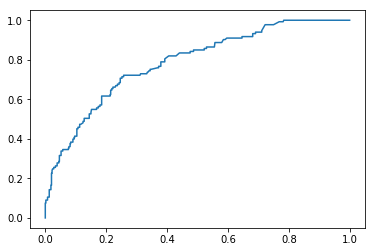

In [235]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
fpr, tpr, _ = roc_curve(Y_train, Y_pred)
plt.plot(fpr, tpr)

In [236]:
o = np.argsort(Y_pred)
df.iloc[o].tail(25)

,guid,label,text
663,30830,1,The current understanding is that [[ interleukin ( IL)-6 ]] in combination with transforming growth factor-β ( TGF-β ) leads to generation of << T helper-17 >> ( Th17 ) lineage cells .
667,30834,1,The current understanding is that interleukin ( IL)-6 in combination with transforming growth factor-β ( [[ TGF-β ]] ) leads to generation of << T helper-17 >> ( Th17 ) lineage cells .
665,30832,1,The current understanding is that interleukin ( IL)-6 in combination with [[ transforming growth factor-β ]] ( TGF-β ) leads to generation of << T helper-17 >> ( Th17 ) lineage cells .
82,30249,1,"Altogether , << Th17 >> cells require IL23 , TGFβ , [[ IL6 ]] , and IL1 for their generation ."
34,30201,0,"Plasticity within this subset is suggested by the existence of IL-17 secreting cells , which , can also secrete [[ interferon-γ ]] , the signature cytokine for Th1 cells or , can co - express the anti - inflammatory transcription factor forkhead ..."
32,30199,0,"Plasticity within this subset is suggested by the existence of [[ IL-17 ]] secreting cells , which , can also secrete interferon-γ , the signature cytokine for Th1 cells or , can co - express the anti - inflammatory transcription factor forkhead ..."
134,30301,0,"Furthermore , [[ IL-33 ]] controlled Bcl6 function at the chromatin level and consequently , augmented cytokine production in memory << TH2 >> cells ."
80,30247,1,"Altogether , << Th17 >> cells require [[ IL23 ]] , TGFβ , IL6 , and IL1 for their generation ."
81,30248,1,"Altogether , << Th17 >> cells require IL23 , [[ TGFβ ]] , IL6 , and IL1 for their generation ."
315,30482,0,"In addition , [[ IL-6 ]] also antagonizes the IL-12– mediated differentiation of << Th1 >> cells ."
